In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [8]:

class Neuron:
    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  
        self.xmid = None  
        self.xout = None  
        self.dxout_dxmid = None  
        self.dxout_dbias = None  
        self.dxmid_dw = None  
        self.dxmid_dxin = None  
        self.dxout_dxin = None  
        self.dxout_dw = None  
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  
        self.dloss_dbias = 0  
 
    def __call__(self, xin):
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()
 
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()
 
        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)
 
        self.get_dxout_dxin()
        self.get_dxout_dw()
 
        return self.xout
 
    def get_xmid(self):
        pass
 
    def get_xout(self):
        pass
 
    def get_dxout_dxmid(self):
        pass
 
    def get_dxout_dbias(self):
        pass  
 
    def get_dxmid_dw(self):
        pass
 
    def get_dxmid_dxin(self):
        pass
 
    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin
 
    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw
 
    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout
 
    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias

In [9]:
import math
 
def relu(x, get_derivative=False):
    return x * (x > 0) if not get_derivative else 1.0 * (x >= 0)
 
def tanh_act(x, get_derivative=False):
    if not get_derivative:
        return math.tanh(x)
    return 1 - math.tanh(x) ** 2
 
def sigmoid_act(x, get_derivative=False):
    if not get_derivative:
        return 1 / (1 + math.exp(-x))
    return sigmoid_act(x) * (1 - sigmoid_act(x))

In [10]:
class NeuronNN(Neuron):
    def __init__(self, n_in, weights_range=None, activation=relu):
        super().__init__(n_in, n_weights_per_edge=1, weights_range=weights_range)
        self.activation = activation
        self.activation_input = None
 
    def get_xmid(self):
        self.xmid = self.weights[:, 0] * self.xin
 
    def get_xout(self):
        self.activation_input = sum(self.xmid.flatten()) + self.bias
        self.xout = self.activation(self.activation_input, get_derivative=False)
 
    def get_dxout_dxmid(self):
        self.dxout_dxmid = self.activation(self.activation_input, get_derivative=True) * np.ones(self.n_in)
 
    def get_dxout_dbias(self):
        self.dxout_dbias = self.activation(self.activation_input, get_derivative=True)
 
    def get_dxmid_dw(self):
        self.dxmid_dw = np.reshape(self.xin, (-1, 1))
 
    def get_dxmid_dxin(self):
        self.dxmid_dxin = self.weights.flatten()

In [11]:
from scipy.interpolate import BSpline
def get_bsplines(x_bounds, n_fun, degree=3, **kwargs):
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun, edge_fun_der = {}, {}
 
    edge_fun[0] = lambda x: x / (1 + np.exp(-x))
    edge_fun_der[0] = lambda x: (1 + np.exp(-x) + x * np.exp(-x)) / np.power((1 + np.exp(-x)), 2)
    
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]
    
    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)
        edge_fun_der[ind_spline + 1] = edge_fun[ind_spline + 1].derivative()
    return edge_fun, edge_fun_der

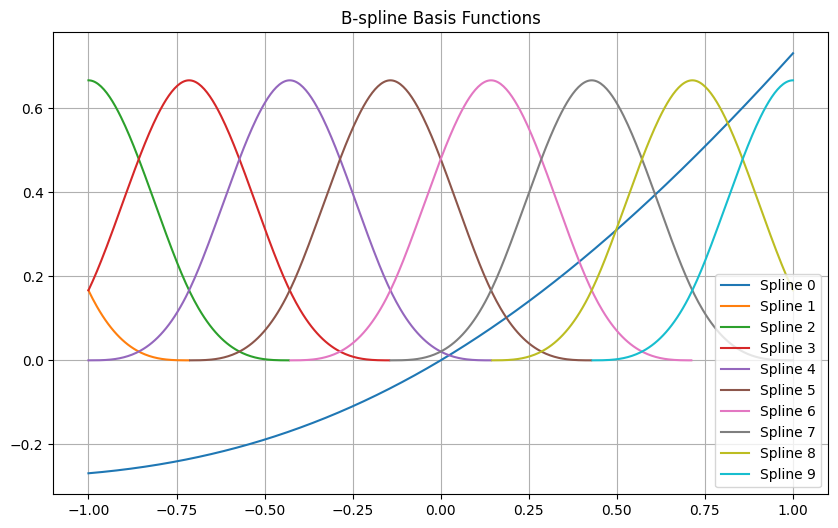

In [12]:
x_bounds = (-1, 1)
n_fun = 10
degree = 3

edge_fun, edge_fun_der = get_bsplines(x_bounds, n_fun, degree)

x_vals = np.linspace(x_bounds[0], x_bounds[1], 500)
plt.figure(figsize=(10, 6))
for key, func in edge_fun.items():
    if callable(func):  
        y_vals = func(x_vals)
        plt.plot(x_vals, y_vals, label=f"Spline {key}")

plt.title("B-spline Basis Functions")
plt.legend()
plt.grid(True)
plt.show()